In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7f8ee0864cc0>)


/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


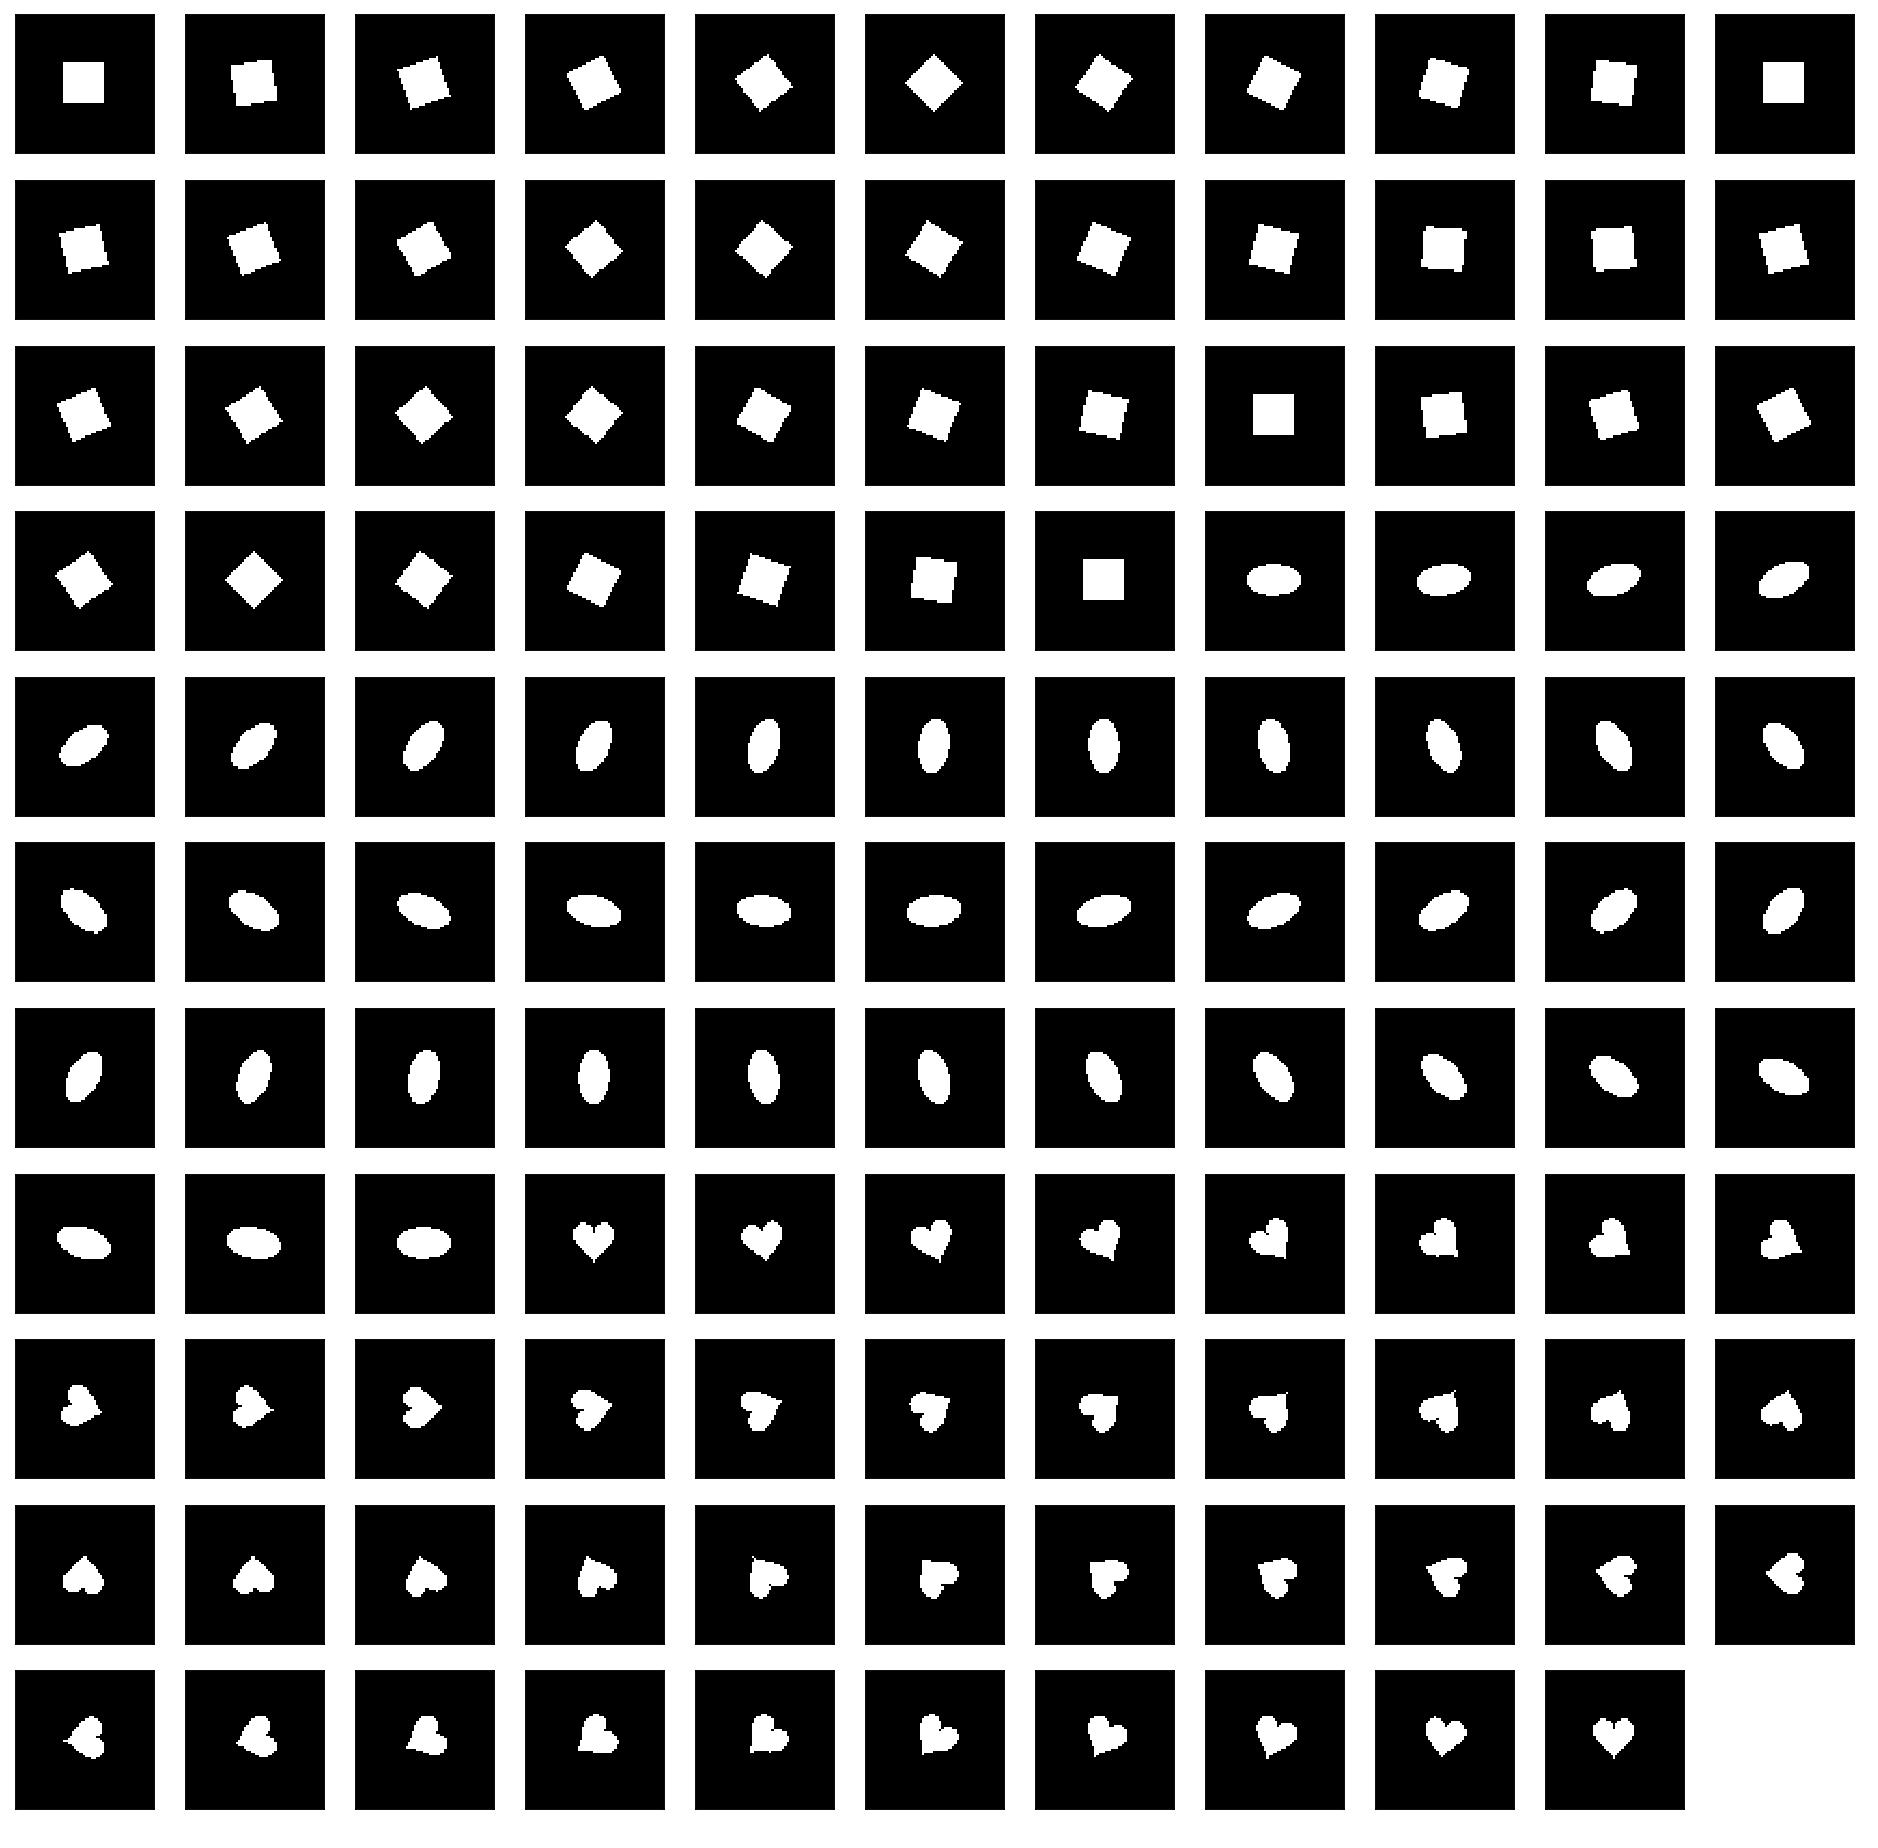

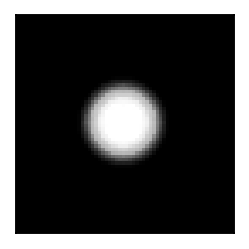

In [2]:
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                      , encoding='bytes')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

# Define number of values per latents and functions to convert to indices
latents_sizes =  np.array([ 1,  3,  6, 40, 32, 32])
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)

# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

from copy import deepcopy
## Fix posX latent to left
#latents_sampled = sample_latent(size=5000)
latents_sampled = deepcopy(latents_classes)
latents_sampled[:, [4,5]] = 15
latents_sampled[:,2]= 5


indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[np.unique(indices_sampled)]

#np.unique(indices_sampled)

# Samples
show_images_grid(imgs_sampled,len(np.unique(indices_sampled)))

# Show the density too to check
show_density(imgs_sampled)



In [3]:
import random
random.seed(69)
ff = imgs_sampled
n_data =  ff.shape[0]
n_train = int(np.ceil(n_data*0.8))

print(n_train)
idx_train = random.sample(range(n_data), n_train)
idx_test = np.delete(range(n_data),idx_train,0)

96


In [4]:
ff.shape[0]*0.8
idx_test

array([  0,   1,   6,  14,  15,  20,  22,  23,  24,  28,  32,  43,  46,
        51,  55,  67,  85,  92,  93,  96, 104, 105, 110, 118])

In [5]:
# split data into train / validation folds
#np.random.seed(42)

img_rows = ff.shape[1]
img_cols = ff.shape[2]

n_pixels = img_rows * img_cols
x_train = ff[idx_train]
x_test = ff[idx_test]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

In [6]:
x_train.shape

(96, 4096)

In [7]:
x_test.shape

(24, 4096)

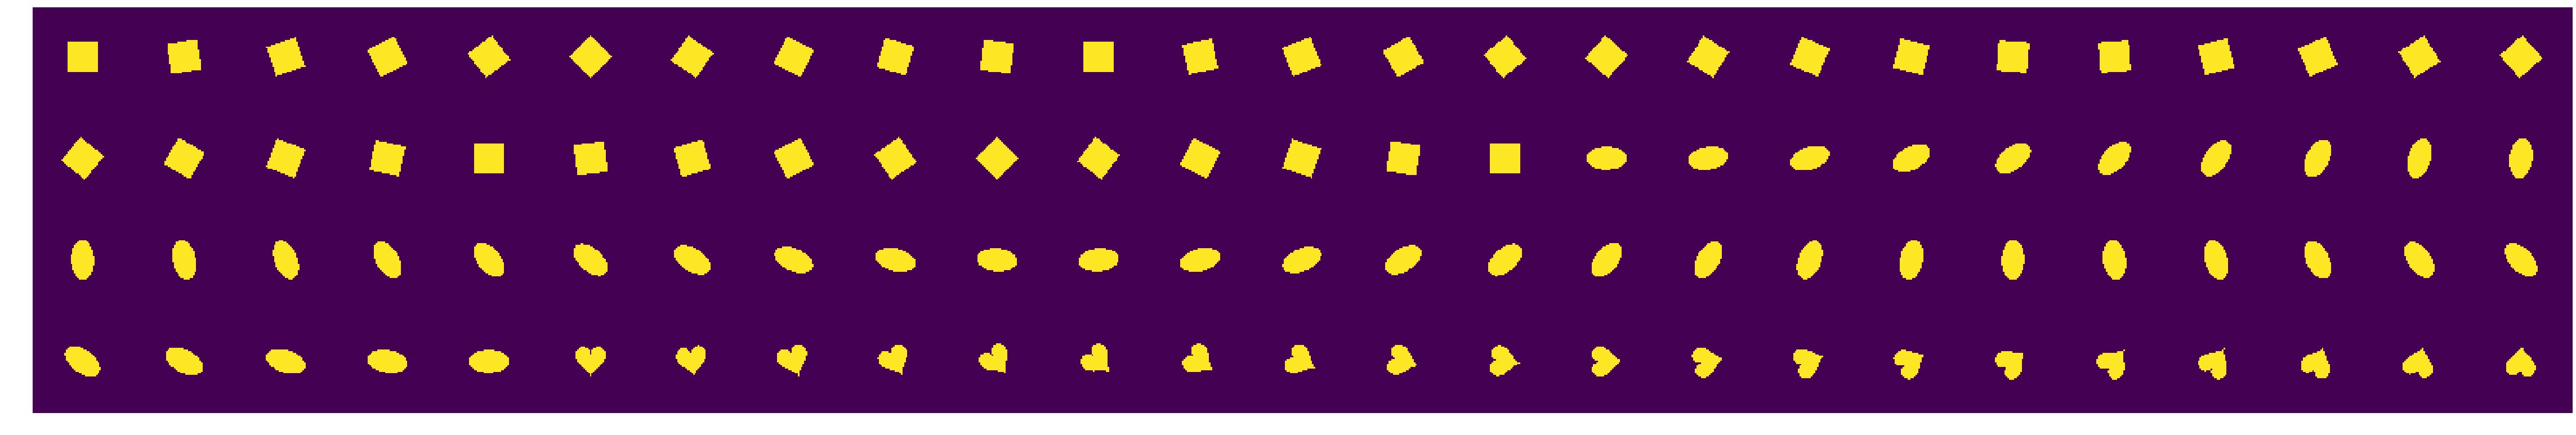

In [8]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(64, 64))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=100, n_cols=25)

In [9]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [10]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [11]:
def plot_results(models,
                 latent_dim,
                 latent_num,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    filename = os.path.join(model_name, "face_over_latent.png")
    n = 20
    #digit_size = 28
    img_rows, img_cols = 64, 64
    figure = np.zeros((img_rows , img_cols * n))
    grid_x = np.linspace(-5, 5, n)
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
    z_sample[0,:] = z_m_m 
    
    for j, xi in enumerate(grid_x):
        z_sample[0,latent_num] = xi
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[0: img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    plt.savefig(filename)
    plt.show()

In [12]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 512
intermediate_dim2 = 256
intermediate_dim3 = 64

batch_size = 20
latent_dim = 2
epochs = 100

In [13]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x1)
x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x3)
z_log_var = Dense(latent_dim, name='z_log_var')(x3)


In [14]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m

    return( z2)

In [15]:
# z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

In [16]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           16448       dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [17]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z')

x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(x2)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2101248   
Total params: 2,249,664
Trainable params: 2,249,664
Non-trainable params: 0
_________________________________________________________________


In [18]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [19]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 2245700   
_________________________________________________________________
decoder (Model)              (None, 4096)              2249664   
Total params: 4,495,364
Trainable params: 4,495,364
Non-trainable params: 0
_________________________________________________________________


In [20]:
epochs = int(1E3)

In [21]:
from keras.callbacks import ModelCheckpoint

'''
saves the model weights after each epoch if the validation loss decreased
'''
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
#model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0, validation_data=(X_test, Y_test), callbacks=[checkpointer])
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None), 
        callbacks=[checkpointer])

Train on 96 samples, validate on 24 samples
Epoch 1/1000
96/96 [==============================] - 1s 8ms/step - loss: 2742.3188 - val_loss: 2098.8696

Epoch 00001: val_loss improved from inf to 2098.86963, saving model to weights.hdf5
Epoch 2/1000
96/96 [==============================] - 0s 486us/step - loss: 1199.2041 - val_loss: 711.0702

Epoch 00002: val_loss improved from 2098.86963 to 711.07024, saving model to weights.hdf5
Epoch 3/1000
96/96 [==============================] - 0s 471us/step - loss: 631.8150 - val_loss: 481.2399

Epoch 00003: val_loss improved from 711.07024 to 481.23988, saving model to weights.hdf5
Epoch 4/1000
96/96 [==============================] - 0s 464us/step - loss: 371.0574 - val_loss: 307.8800

Epoch 00004: val_loss improved from 481.23988 to 307.88002, saving model to weights.hdf5
Epoch 5/1000
96/96 [==============================] - 0s 479us/step - loss: 283.8853 - val_loss: 269.6936

Epoch 00005: val_loss improved from 307.88002 to 269.69364, saving m

96/96 [==============================] - 0s 417us/step - loss: 182.7694 - val_loss: 191.0022

Epoch 00045: val_loss did not improve from 190.78968
Epoch 46/1000
96/96 [==============================] - 0s 507us/step - loss: 182.2860 - val_loss: 191.7539

Epoch 00046: val_loss did not improve from 190.78968
Epoch 47/1000
96/96 [==============================] - 0s 520us/step - loss: 181.8246 - val_loss: 190.9644

Epoch 00047: val_loss did not improve from 190.78968
Epoch 48/1000
96/96 [==============================] - 0s 546us/step - loss: 181.3391 - val_loss: 189.6814

Epoch 00048: val_loss improved from 190.78968 to 189.68136, saving model to weights.hdf5
Epoch 49/1000
96/96 [==============================] - 0s 458us/step - loss: 181.2598 - val_loss: 191.6513

Epoch 00049: val_loss did not improve from 189.68136
Epoch 50/1000
96/96 [==============================] - 0s 524us/step - loss: 181.0310 - val_loss: 190.9663

Epoch 00050: val_loss did not improve from 189.68136
Epoch 51/100

96/96 [==============================] - 0s 430us/step - loss: 103.1798 - val_loss: 129.7861

Epoch 00090: val_loss did not improve from 128.72531
Epoch 91/1000
96/96 [==============================] - 0s 508us/step - loss: 103.2939 - val_loss: 128.8779

Epoch 00091: val_loss did not improve from 128.72531
Epoch 92/1000
96/96 [==============================] - 0s 529us/step - loss: 101.9666 - val_loss: 125.9282

Epoch 00092: val_loss improved from 128.72531 to 125.92819, saving model to weights.hdf5
Epoch 93/1000
96/96 [==============================] - 0s 478us/step - loss: 100.7218 - val_loss: 130.5104

Epoch 00093: val_loss did not improve from 125.92819
Epoch 94/1000
96/96 [==============================] - 0s 493us/step - loss: 101.5799 - val_loss: 127.9463

Epoch 00094: val_loss did not improve from 125.92819
Epoch 95/1000
96/96 [==============================] - 0s 523us/step - loss: 98.3982 - val_loss: 126.1054

Epoch 00095: val_loss did not improve from 125.92819
Epoch 96/1000

Epoch 138/1000
96/96 [==============================] - 0s 482us/step - loss: 63.3695 - val_loss: 104.8935

Epoch 00138: val_loss did not improve from 103.43565
Epoch 139/1000
96/96 [==============================] - 0s 503us/step - loss: 63.7705 - val_loss: 108.5985

Epoch 00139: val_loss did not improve from 103.43565
Epoch 140/1000
96/96 [==============================] - 0s 521us/step - loss: 63.6324 - val_loss: 107.4518

Epoch 00140: val_loss did not improve from 103.43565
Epoch 141/1000
96/96 [==============================] - 0s 552us/step - loss: 62.6410 - val_loss: 105.1237

Epoch 00141: val_loss did not improve from 103.43565
Epoch 142/1000
96/96 [==============================] - 0s 547us/step - loss: 61.4699 - val_loss: 108.7029

Epoch 00142: val_loss did not improve from 103.43565
Epoch 143/1000
96/96 [==============================] - 0s 553us/step - loss: 60.7690 - val_loss: 110.0805

Epoch 00143: val_loss did not improve from 103.43565
Epoch 144/1000
96/96 [============

96/96 [==============================] - 0s 557us/step - loss: 50.4267 - val_loss: 106.8816

Epoch 00188: val_loss did not improve from 100.85207
Epoch 189/1000
96/96 [==============================] - 0s 546us/step - loss: 52.2417 - val_loss: 103.0314

Epoch 00189: val_loss did not improve from 100.85207
Epoch 190/1000
96/96 [==============================] - 0s 545us/step - loss: 51.5312 - val_loss: 119.0880

Epoch 00190: val_loss did not improve from 100.85207
Epoch 191/1000
96/96 [==============================] - 0s 554us/step - loss: 50.9878 - val_loss: 105.9368

Epoch 00191: val_loss did not improve from 100.85207
Epoch 192/1000
96/96 [==============================] - 0s 569us/step - loss: 48.6882 - val_loss: 116.9570

Epoch 00192: val_loss did not improve from 100.85207
Epoch 193/1000
96/96 [==============================] - 0s 571us/step - loss: 49.6852 - val_loss: 113.1176

Epoch 00193: val_loss did not improve from 100.85207
Epoch 194/1000
96/96 [===========================

96/96 [==============================] - 0s 546us/step - loss: 39.2315 - val_loss: 120.2011

Epoch 00239: val_loss did not improve from 100.85207
Epoch 240/1000
96/96 [==============================] - 0s 559us/step - loss: 38.2549 - val_loss: 120.6418

Epoch 00240: val_loss did not improve from 100.85207
Epoch 241/1000
96/96 [==============================] - 0s 545us/step - loss: 38.9156 - val_loss: 119.8536

Epoch 00241: val_loss did not improve from 100.85207
Epoch 242/1000
96/96 [==============================] - 0s 564us/step - loss: 42.3648 - val_loss: 120.6827

Epoch 00242: val_loss did not improve from 100.85207
Epoch 243/1000
96/96 [==============================] - 0s 568us/step - loss: 46.0190 - val_loss: 125.6464

Epoch 00243: val_loss did not improve from 100.85207
Epoch 244/1000
96/96 [==============================] - 0s 532us/step - loss: 43.9371 - val_loss: 126.8853

Epoch 00244: val_loss did not improve from 100.85207
Epoch 245/1000
96/96 [===========================

96/96 [==============================] - 0s 512us/step - loss: 31.8559 - val_loss: 147.1877

Epoch 00290: val_loss did not improve from 100.85207
Epoch 291/1000
96/96 [==============================] - 0s 553us/step - loss: 34.2785 - val_loss: 131.6311

Epoch 00291: val_loss did not improve from 100.85207
Epoch 292/1000
96/96 [==============================] - 0s 558us/step - loss: 31.7806 - val_loss: 136.2282

Epoch 00292: val_loss did not improve from 100.85207
Epoch 293/1000
96/96 [==============================] - 0s 562us/step - loss: 31.8005 - val_loss: 134.0110

Epoch 00293: val_loss did not improve from 100.85207
Epoch 294/1000
96/96 [==============================] - 0s 559us/step - loss: 30.4964 - val_loss: 126.4490

Epoch 00294: val_loss did not improve from 100.85207
Epoch 295/1000
96/96 [==============================] - 0s 567us/step - loss: 29.0377 - val_loss: 143.0393

Epoch 00295: val_loss did not improve from 100.85207
Epoch 296/1000
96/96 [===========================

96/96 [==============================] - 0s 552us/step - loss: 22.2363 - val_loss: 156.9110

Epoch 00341: val_loss did not improve from 100.85207
Epoch 342/1000
96/96 [==============================] - 0s 553us/step - loss: 22.9880 - val_loss: 147.4546

Epoch 00342: val_loss did not improve from 100.85207
Epoch 343/1000
96/96 [==============================] - 0s 568us/step - loss: 23.2228 - val_loss: 141.0070

Epoch 00343: val_loss did not improve from 100.85207
Epoch 344/1000
96/96 [==============================] - 0s 565us/step - loss: 23.6043 - val_loss: 153.3223

Epoch 00344: val_loss did not improve from 100.85207
Epoch 345/1000
96/96 [==============================] - 0s 540us/step - loss: 23.1350 - val_loss: 151.9262

Epoch 00345: val_loss did not improve from 100.85207
Epoch 346/1000
96/96 [==============================] - 0s 563us/step - loss: 23.5089 - val_loss: 153.2947

Epoch 00346: val_loss did not improve from 100.85207
Epoch 347/1000
96/96 [===========================

96/96 [==============================] - 0s 551us/step - loss: 26.7281 - val_loss: 164.4157

Epoch 00392: val_loss did not improve from 100.85207
Epoch 393/1000
96/96 [==============================] - 0s 553us/step - loss: 26.0588 - val_loss: 159.4489

Epoch 00393: val_loss did not improve from 100.85207
Epoch 394/1000
96/96 [==============================] - 0s 562us/step - loss: 24.0588 - val_loss: 166.1678

Epoch 00394: val_loss did not improve from 100.85207
Epoch 395/1000
96/96 [==============================] - 0s 550us/step - loss: 25.1021 - val_loss: 169.3397

Epoch 00395: val_loss did not improve from 100.85207
Epoch 396/1000
96/96 [==============================] - 0s 551us/step - loss: 23.0654 - val_loss: 168.2706

Epoch 00396: val_loss did not improve from 100.85207
Epoch 397/1000
96/96 [==============================] - 0s 561us/step - loss: 24.4780 - val_loss: 158.3709

Epoch 00397: val_loss did not improve from 100.85207
Epoch 398/1000
96/96 [===========================

96/96 [==============================] - 0s 578us/step - loss: 20.6911 - val_loss: 163.0899

Epoch 00443: val_loss did not improve from 100.85207
Epoch 444/1000
96/96 [==============================] - 0s 551us/step - loss: 20.1633 - val_loss: 179.8065

Epoch 00444: val_loss did not improve from 100.85207
Epoch 445/1000
96/96 [==============================] - 0s 556us/step - loss: 19.3708 - val_loss: 157.8161

Epoch 00445: val_loss did not improve from 100.85207
Epoch 446/1000
96/96 [==============================] - 0s 552us/step - loss: 19.3200 - val_loss: 167.3072

Epoch 00446: val_loss did not improve from 100.85207
Epoch 447/1000
96/96 [==============================] - 0s 540us/step - loss: 17.8571 - val_loss: 166.1560

Epoch 00447: val_loss did not improve from 100.85207
Epoch 448/1000
96/96 [==============================] - 0s 543us/step - loss: 16.9861 - val_loss: 170.0694

Epoch 00448: val_loss did not improve from 100.85207
Epoch 449/1000
96/96 [===========================

96/96 [==============================] - 0s 563us/step - loss: 22.2118 - val_loss: 186.3014

Epoch 00494: val_loss did not improve from 100.85207
Epoch 495/1000
96/96 [==============================] - 0s 570us/step - loss: 26.3829 - val_loss: 191.8616

Epoch 00495: val_loss did not improve from 100.85207
Epoch 496/1000
96/96 [==============================] - 0s 552us/step - loss: 24.5869 - val_loss: 179.9744

Epoch 00496: val_loss did not improve from 100.85207
Epoch 497/1000
96/96 [==============================] - 0s 552us/step - loss: 23.9098 - val_loss: 191.4966

Epoch 00497: val_loss did not improve from 100.85207
Epoch 498/1000
96/96 [==============================] - 0s 559us/step - loss: 28.1518 - val_loss: 190.7132

Epoch 00498: val_loss did not improve from 100.85207
Epoch 499/1000
96/96 [==============================] - 0s 553us/step - loss: 35.8190 - val_loss: 157.9469

Epoch 00499: val_loss did not improve from 100.85207
Epoch 500/1000
96/96 [===========================

96/96 [==============================] - 0s 561us/step - loss: 14.1526 - val_loss: 160.1496

Epoch 00545: val_loss did not improve from 100.85207
Epoch 546/1000
96/96 [==============================] - 0s 548us/step - loss: 15.4506 - val_loss: 171.3413

Epoch 00546: val_loss did not improve from 100.85207
Epoch 547/1000
96/96 [==============================] - 0s 552us/step - loss: 14.5678 - val_loss: 167.2453

Epoch 00547: val_loss did not improve from 100.85207
Epoch 548/1000
96/96 [==============================] - 0s 566us/step - loss: 14.3795 - val_loss: 174.7448

Epoch 00548: val_loss did not improve from 100.85207
Epoch 549/1000
96/96 [==============================] - 0s 556us/step - loss: 14.0949 - val_loss: 160.7121

Epoch 00549: val_loss did not improve from 100.85207
Epoch 550/1000
96/96 [==============================] - 0s 541us/step - loss: 14.5742 - val_loss: 179.4838

Epoch 00550: val_loss did not improve from 100.85207
Epoch 551/1000
96/96 [===========================

96/96 [==============================] - 0s 557us/step - loss: 26.6051 - val_loss: 201.0770

Epoch 00596: val_loss did not improve from 100.85207
Epoch 597/1000
96/96 [==============================] - 0s 557us/step - loss: 28.9296 - val_loss: 263.6450

Epoch 00597: val_loss did not improve from 100.85207
Epoch 598/1000
96/96 [==============================] - 0s 571us/step - loss: 25.0726 - val_loss: 189.0856

Epoch 00598: val_loss did not improve from 100.85207
Epoch 599/1000
96/96 [==============================] - 0s 569us/step - loss: 26.1286 - val_loss: 215.0451

Epoch 00599: val_loss did not improve from 100.85207
Epoch 600/1000
96/96 [==============================] - 0s 535us/step - loss: 24.9832 - val_loss: 187.3569

Epoch 00600: val_loss did not improve from 100.85207
Epoch 601/1000
96/96 [==============================] - 0s 570us/step - loss: 24.8243 - val_loss: 218.7623

Epoch 00601: val_loss did not improve from 100.85207
Epoch 602/1000
96/96 [===========================

96/96 [==============================] - 0s 551us/step - loss: 12.5128 - val_loss: 181.4148

Epoch 00647: val_loss did not improve from 100.85207
Epoch 648/1000
96/96 [==============================] - 0s 550us/step - loss: 11.7025 - val_loss: 192.5351

Epoch 00648: val_loss did not improve from 100.85207
Epoch 649/1000
96/96 [==============================] - 0s 552us/step - loss: 11.9221 - val_loss: 180.3897

Epoch 00649: val_loss did not improve from 100.85207
Epoch 650/1000
96/96 [==============================] - 0s 524us/step - loss: 12.1310 - val_loss: 191.3226

Epoch 00650: val_loss did not improve from 100.85207
Epoch 651/1000
96/96 [==============================] - 0s 572us/step - loss: 11.4813 - val_loss: 186.6763

Epoch 00651: val_loss did not improve from 100.85207
Epoch 652/1000
96/96 [==============================] - 0s 560us/step - loss: 11.6727 - val_loss: 193.1298

Epoch 00652: val_loss did not improve from 100.85207
Epoch 653/1000
96/96 [===========================

96/96 [==============================] - 0s 558us/step - loss: 29.6951 - val_loss: 228.4822

Epoch 00698: val_loss did not improve from 100.85207
Epoch 699/1000
96/96 [==============================] - 0s 545us/step - loss: 26.1894 - val_loss: 213.4281

Epoch 00699: val_loss did not improve from 100.85207
Epoch 700/1000
96/96 [==============================] - 0s 538us/step - loss: 28.5478 - val_loss: 208.3055

Epoch 00700: val_loss did not improve from 100.85207
Epoch 701/1000
96/96 [==============================] - 0s 553us/step - loss: 21.2487 - val_loss: 192.0452

Epoch 00701: val_loss did not improve from 100.85207
Epoch 702/1000
96/96 [==============================] - 0s 553us/step - loss: 25.8371 - val_loss: 233.9412

Epoch 00702: val_loss did not improve from 100.85207
Epoch 703/1000
96/96 [==============================] - 0s 564us/step - loss: 27.8793 - val_loss: 264.4265

Epoch 00703: val_loss did not improve from 100.85207
Epoch 704/1000
96/96 [===========================

96/96 [==============================] - 0s 556us/step - loss: 11.6421 - val_loss: 193.8866

Epoch 00749: val_loss did not improve from 100.85207
Epoch 750/1000
96/96 [==============================] - 0s 548us/step - loss: 11.5084 - val_loss: 204.8146

Epoch 00750: val_loss did not improve from 100.85207
Epoch 751/1000
96/96 [==============================] - 0s 550us/step - loss: 11.3003 - val_loss: 201.8483

Epoch 00751: val_loss did not improve from 100.85207
Epoch 752/1000
96/96 [==============================] - 0s 565us/step - loss: 11.0324 - val_loss: 196.9041

Epoch 00752: val_loss did not improve from 100.85207
Epoch 753/1000
96/96 [==============================] - 0s 557us/step - loss: 11.0048 - val_loss: 199.7705

Epoch 00753: val_loss did not improve from 100.85207
Epoch 754/1000
96/96 [==============================] - 0s 528us/step - loss: 10.8321 - val_loss: 193.0079

Epoch 00754: val_loss did not improve from 100.85207
Epoch 755/1000
96/96 [===========================

96/96 [==============================] - 0s 548us/step - loss: 10.2995 - val_loss: 195.9188

Epoch 00800: val_loss did not improve from 100.85207
Epoch 801/1000
96/96 [==============================] - 0s 557us/step - loss: 10.8838 - val_loss: 200.8846

Epoch 00801: val_loss did not improve from 100.85207
Epoch 802/1000
96/96 [==============================] - 0s 555us/step - loss: 11.1797 - val_loss: 205.2349

Epoch 00802: val_loss did not improve from 100.85207
Epoch 803/1000
96/96 [==============================] - 0s 565us/step - loss: 11.3915 - val_loss: 208.7402

Epoch 00803: val_loss did not improve from 100.85207
Epoch 804/1000
96/96 [==============================] - 0s 552us/step - loss: 12.1205 - val_loss: 209.8144

Epoch 00804: val_loss did not improve from 100.85207
Epoch 805/1000
96/96 [==============================] - 0s 559us/step - loss: 11.8789 - val_loss: 207.7967

Epoch 00805: val_loss did not improve from 100.85207
Epoch 806/1000
96/96 [===========================

96/96 [==============================] - 0s 542us/step - loss: 10.4967 - val_loss: 202.8260

Epoch 00851: val_loss did not improve from 100.85207
Epoch 852/1000
96/96 [==============================] - 0s 560us/step - loss: 11.3476 - val_loss: 209.2382

Epoch 00852: val_loss did not improve from 100.85207
Epoch 853/1000
96/96 [==============================] - 0s 544us/step - loss: 10.6070 - val_loss: 230.4567

Epoch 00853: val_loss did not improve from 100.85207
Epoch 854/1000
96/96 [==============================] - 0s 545us/step - loss: 10.5953 - val_loss: 213.1921

Epoch 00854: val_loss did not improve from 100.85207
Epoch 855/1000
96/96 [==============================] - 0s 544us/step - loss: 10.5837 - val_loss: 222.4200

Epoch 00855: val_loss did not improve from 100.85207
Epoch 856/1000
96/96 [==============================] - 0s 564us/step - loss: 10.3754 - val_loss: 216.4716

Epoch 00856: val_loss did not improve from 100.85207
Epoch 857/1000
96/96 [===========================

96/96 [==============================] - 0s 565us/step - loss: 12.3506 - val_loss: 210.2232

Epoch 00902: val_loss did not improve from 100.85207
Epoch 903/1000
96/96 [==============================] - 0s 555us/step - loss: 11.1009 - val_loss: 204.9147

Epoch 00903: val_loss did not improve from 100.85207
Epoch 904/1000
96/96 [==============================] - 0s 570us/step - loss: 11.0889 - val_loss: 199.4477

Epoch 00904: val_loss did not improve from 100.85207
Epoch 905/1000
96/96 [==============================] - 0s 553us/step - loss: 10.6830 - val_loss: 204.2814

Epoch 00905: val_loss did not improve from 100.85207
Epoch 906/1000
96/96 [==============================] - 0s 543us/step - loss: 10.7614 - val_loss: 211.9674

Epoch 00906: val_loss did not improve from 100.85207
Epoch 907/1000
96/96 [==============================] - 0s 549us/step - loss: 10.9533 - val_loss: 228.7122

Epoch 00907: val_loss did not improve from 100.85207
Epoch 908/1000
96/96 [===========================

96/96 [==============================] - 0s 566us/step - loss: 9.5738 - val_loss: 229.5804

Epoch 00953: val_loss did not improve from 100.85207
Epoch 954/1000
96/96 [==============================] - 0s 544us/step - loss: 9.6133 - val_loss: 217.1431

Epoch 00954: val_loss did not improve from 100.85207
Epoch 955/1000
96/96 [==============================] - 0s 554us/step - loss: 9.2900 - val_loss: 231.2693

Epoch 00955: val_loss did not improve from 100.85207
Epoch 956/1000
96/96 [==============================] - 0s 553us/step - loss: 10.5531 - val_loss: 247.2534

Epoch 00956: val_loss did not improve from 100.85207
Epoch 957/1000
96/96 [==============================] - 0s 542us/step - loss: 11.6916 - val_loss: 248.7481

Epoch 00957: val_loss did not improve from 100.85207
Epoch 958/1000
96/96 [==============================] - 0s 561us/step - loss: 14.4219 - val_loss: 221.5774

Epoch 00958: val_loss did not improve from 100.85207
Epoch 959/1000
96/96 [==============================

In [22]:
z_output = sess.run( z_mean, feed_dict={'encoder_input: 0':x_train})

In [23]:
z_m_m = np.mean(z_output,axis=0)
z_m_m

array([0.12817204, 0.14783967], dtype=float32)

In [24]:
np.cov(z_output.T)

array([[2.84460267, 0.39013891],
       [0.39013891, 2.372855  ]])

Plot the Pearson correlation among Z

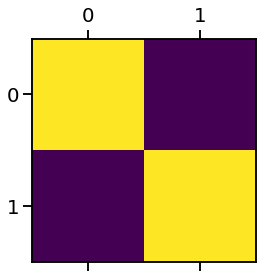

In [25]:
plt.matshow(np.corrcoef(z_output.T))

In [26]:
z_m_m

array([0.12817204, 0.14783967], dtype=float32)

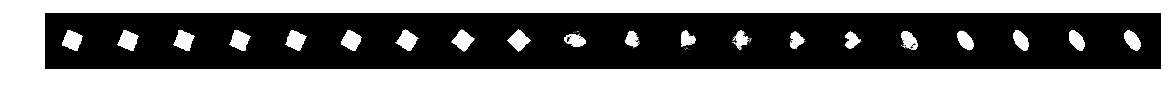

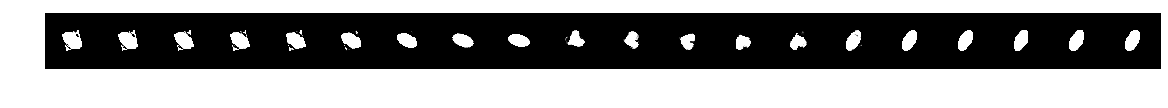

In [27]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")